# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 49

**Author 1 (sciper):** Mariane Brodier (250488)  
**Author 2 (sciper):** Lucas Bost (270139)   
**Author 3 (sciper):** Nicolas Delamaide (271789)    

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

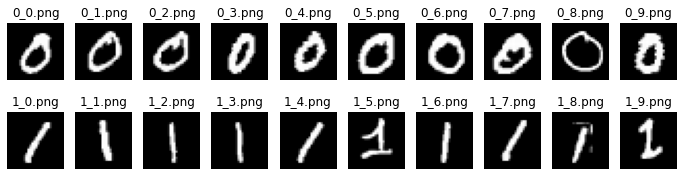

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

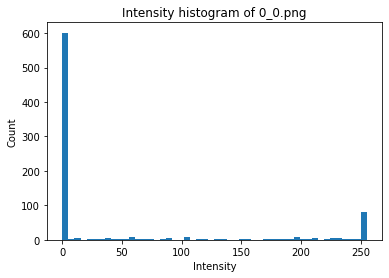

In [4]:
plt.hist(zeros_im[0].ravel(), bins=50)
plt.title('Intensity histogram of 0_0.png')
plt.ylabel('Count')
plt.xlabel('Intensity')
plt.show()

#### A. Implementation
##### Pre-processing

We can see that from the histogram above of the first image (0_0.png) that there are mainly pixels of two intensities : 0 (black) for the backgroung and 1 (white) for the digit. We just need to use a treshold to do the image binarization, for example by using Otsu's method from skimage.

In [5]:
from skimage.filters import threshold_otsu
import numpy as np

# Binarization
threshold0 = threshold_otsu(zeros_im)
binary0 = np.asarray((zeros_im > threshold0).astype(float))
binary0[binary0==1] = 255

threshold1 = threshold_otsu(ones_im)
binary1 = np.asarray((ones_im > threshold1).astype(float))
binary1[binary1==1] = 255

We then can find the contours of the digits using skimage again.

In [6]:
from skimage.measure import find_contours

def contours(zeros, ones):
    contour0 = []
    contour1 = []

    for i in range(zeros.shape[0]):
        temp0 = np.asarray(find_contours(zeros[i], 2.0), dtype='object')
        contour0.append(np.concatenate((temp0[0], temp0[1]), axis=0))
        contour1.append(np.squeeze(np.asarray(find_contours(ones[i], 2.0), dtype='object')))
    
    return contour0, contour1

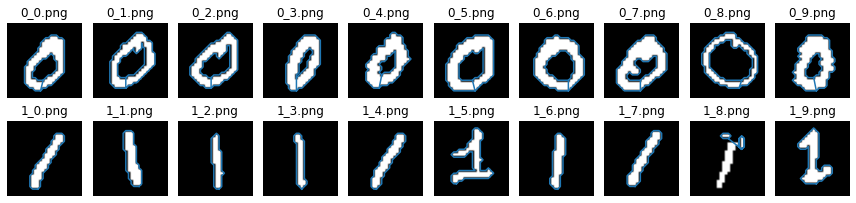

In [7]:
contour0, contour1 = contours(binary0, binary1)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, im, cont, nm in zip(axes[0], binary0, contour0, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.plot(cont[:, 1], cont[:, 0])
    ax.axis('off')
    ax.set_title(nm)
for ax, im, cont, nm in zip(axes[1][:8], binary1[:8], contour1[:8], ones_names[:8]):
    ax.imshow(im, cmap='gray')
    ax.plot(cont[:, 1], cont[:, 0])
    ax.axis('off')
    ax.set_title(nm)

# Plot 1_8.png
axes[1][8].imshow(binary1[8], cmap='gray')
cont8 = np.concatenate((contour1[8][0], contour1[8][1], contour1[8][1]), axis=0)
axes[1][8].plot(cont8[:, 1], cont8[:, 0])
axes[1][8].axis('off')
axes[1][8].set_title(ones_names[8])

# Plot 1_9.png
axes[1][-1].imshow(binary1[-1], cmap='gray')
axes[1][-1].plot(contour1[-1][:, 1], contour1[-1][:, 0])
axes[1][-1].axis('off')
axes[1][-1].set_title(ones_names[-1])
    
fig.tight_layout()

It seems like that there is an issue with the contour of the image 1_8.png, the contour doesn't match the shape of the digit 1. This is probably due to the fact that there are white pixels on the original image that don't really belong to the pixels of the 1, like some kind of noise. We can do an opening to remove those pixels and only keep the pixels that form the digit 1.

In [8]:
from skimage.morphology import square
from skimage.morphology.binary import binary_opening
    
# Opening on 1_8.png
binary1[8] = binary_opening(binary1[8], square(2))
binary1[8][binary1[8] == 1] = 255   

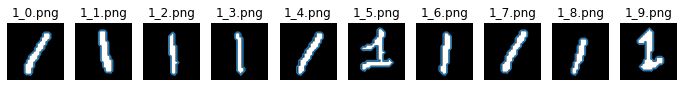

In [9]:
# Plot images
fig, axes = plt.subplots(1, len(binary1), figsize=(12, 3))

for ax, im, nm in zip(axes, binary1, ones_names):
    contour = np.squeeze(np.asarray(find_contours(im, 2.0)))
    ax.imshow(im, cmap='gray')
    ax.plot(contour[:, 1], contour[:, 0])
    ax.axis('off')
    ax.set_title(nm)

##### Fourrier descriptors

Now that we have the contours, we can find the fourier descriptors. We need to build the u_k signal from the countour coordinates as complex numbers then calculate the DFT.

In [10]:
# Finds the contour and returns the DFT
def fourrier(image):
    
    contour = np.squeeze(np.asarray(find_contours(image, 2.0), dtype='object'))
    
    if (contour.ndim == 1): # Need to concatenate contour of digit 0
        contour = np.concatenate((contour[0], contour[1]), axis=0)
        
    u_k = contour[:, 0] + 1j * contour[:, 1] # Create the complex number
    FFT = np.fft.fft(u_k)
    
    return FFT

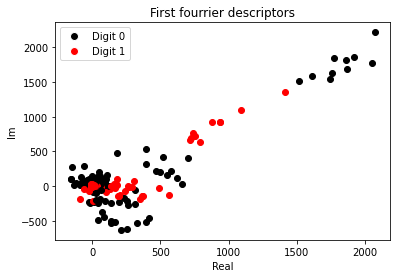

In [11]:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Digit 0',
                          markerfacecolor='k', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Digit 1',
                          markerfacecolor='r', markersize=8)]
plt.figure()
plt.title('First fourrier descriptors')
plt.xlabel('Real')
plt.ylabel('Im')
plt.legend(handles=legend_elements)

for im0, im1, nm0, nm1 in zip(binary0, binary1, zeros_names, ones_names):
    
    # Digit 0
    fft0 = fourrier(im0)
    plt.scatter(fft0.real, fft0.imag, c='k')
    
    # Digit 1
    fft1 = fourrier(im1)
    plt.scatter(fft1.real, fft1.imag, c='r')

We can see that we cannot separate the two digits from the Fourier descriptors alone. In class, we saw that we can use the amplitude of the two first fourier descriptors as features, we will try this approach.

In [12]:
def plotFourier(zeros, ones, name0=zeros_names, name1=ones_names, handle_legend=legend_elements):
    plt.figure()
    plt.title('Amplitude of first two Fourier descriptors')
    plt.xlabel('A1')
    plt.ylabel('A2')
    plt.legend(handles=handle_legend)

    for im0, im1, nm0, nm1 in zip(zeros, ones, name0, name1):
    
        # Digit 0
        fft0 = fourrier(im0)
        A1_0 = abs(fft0[1]) # First amplitude
        A2_0 = abs(fft0[2]) # Second amplitude
        plt.scatter(A1_0, A2_0, c='k')
    
        # Digit 1
        fft1 = fourrier(im1)
        A1_1 = abs(fft1[1]) # First amplitude
        A2_1 = abs(fft1[2]) # Second amplitude
        plt.scatter(A1_1, A2_1, c='r')

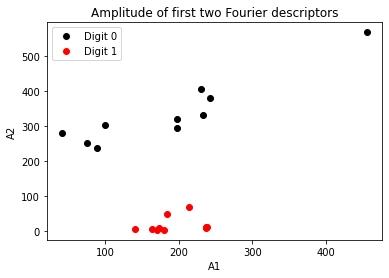

In [13]:
plotFourier(binary0, binary1)

We can see that the vectors of the digit 0 are on the right of the plot while the vectors of the digit 1 are on the left hand side. They are also linearly separable, thus the amplitudes of the first two Fourier descriptors seem to be good features.

#### B. Showing invariance of rotation, translation and scaling

In [14]:
import cv2 as cv

def rotate(images, alpha):
    out = []
    for im in images:
        M = cv.getRotationMatrix2D((im.shape[1]//2, im.shape[0]//2), alpha, 1)
        rotated = cv.warpAffine(im, M, (im.shape[1], im.shape[0]))
        out.append(rotated)
    return np.asarray(out)

In [15]:
# Plots the digits along with their contours
def plotDigits(zeros, ones, zeros_contour, ones_contour, name0 = zeros_names, name1 = ones_names):
    fig, axes = plt.subplots(2, len(zeros), figsize=(12, 3))
    for ax, im, cont, nm in zip(axes[0], zeros, zeros_contour, name0):
        ax.imshow(im, cmap='gray')
        ax.plot(cont[:, 1], cont[:, 0])
        ax.axis('off')
        ax.set_title(nm)
    for ax, im, cont, nm in zip(axes[1], ones, ones_contour, name1):
        ax.imshow(im, cmap='gray')
        ax.plot(cont[:, 1], cont[:, 0])
        ax.axis('off')
        ax.set_title(nm)

In [16]:
# Performs image binarization
def binarization(zeros, ones, opening=True):
    
    threshold0 = threshold_otsu(zeros)
    binary0 = np.asarray((zeros > threshold0).astype(float))
    binary0[binary0==1] = 255

    threshold1 = threshold_otsu(ones)
    binary1 = np.asarray((ones > threshold1).astype(float))
    binary1[binary1==1] = 255
    
    if opening:
       # Opening on 1_8.png
        binary1[8] = binary_opening(binary1[8], square(2))
        binary1[8][binary1[8] == 1] = 255
    
    return binary0, binary1

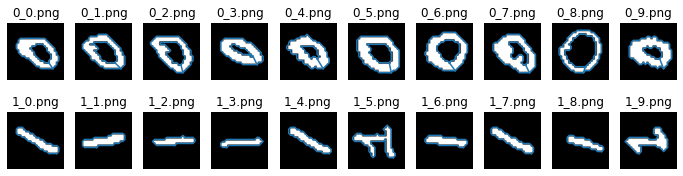

In [17]:
rotated_zeros = rotate(zeros_im, 90)
rotated_ones = rotate(ones_im, 90)

# Binarization
rotated_bin0, rotated_bin1 = binarization(rotated_zeros, rotated_ones)

# Contours
rotated_contour0, rotated_contour1 = contours(rotated_bin0, rotated_bin1)

plotDigits(rotated_bin0, rotated_bin1, rotated_contour0, rotated_contour1)

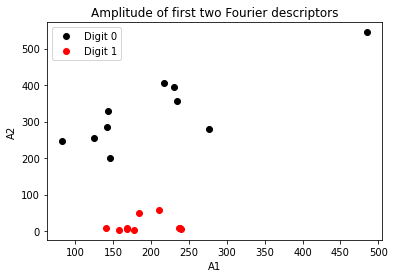

In [18]:
plotFourier(rotated_bin0, rotated_bin1)

We can see that it still works after rotating the images. So this method is rotation invariant.

In [19]:
def translate(images, x, y):
    out = []
    for im in images:
        M = np.float32([[1,0,x],[0,1,y]])
        translated = cv.warpAffine(im, M, (im.shape[1], im.shape[0]))
        out.append(translated)
    return np.asarray(out)

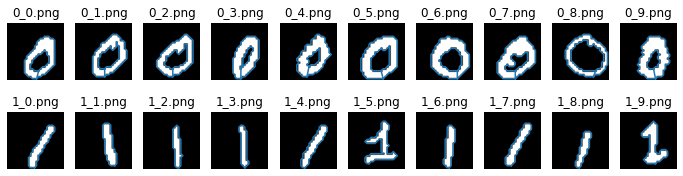

In [20]:
translated_zeros = translate(zeros_im, 2, 2)
translated_ones = translate(ones_im, 2, 2)

# Binarization
trans_bin0, trans_bin1 = binarization(translated_zeros, translated_ones)

# Contours
trans_contour0, trans_contour1 = contours(trans_bin0, trans_bin1)

plotDigits(trans_bin0, trans_bin1, trans_contour0, trans_contour1)

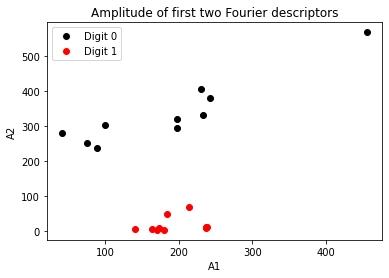

In [21]:
plotFourier(trans_bin0, trans_bin1)

Once again, we see that the separation is still working so the method is translation invariant.

In [22]:
def scale(images, scaling):
    out = []
    for im in images:
        M = cv.getRotationMatrix2D((im.shape[1]//2, im.shape[0]//2), 0, scaling)
        scaled = cv.warpAffine(im, M, (im.shape[1], im.shape[0]))
        out.append(scaled)
    return np.asarray(out)

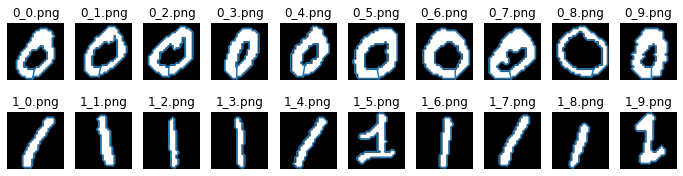

In [23]:
scaled_zeros = scale(zeros_im, 1.2)
scaled_ones = scale(ones_im, 1.2)

# Binarization
scale_bin0, scale_bin1 = binarization(scaled_zeros, scaled_ones)

# Contours
scaled_contour0, scaled_contour1 = contours(scale_bin0, scale_bin1)

plotDigits(scale_bin0, scale_bin1, scaled_contour0, scaled_contour1)

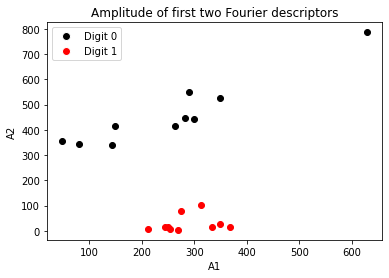

In [24]:
plotFourier(scale_bin0, scale_bin1)

The separation is still correct so it is scaling invariant

After rotating, translating or scaling the images, we saw that the separation was correct in any case. That means that this method is rotation invariant, translation invariant and scaling invariant. It is quite logic because on one hand the translation affects only the zeroth Fourrier coefficient and we are using only the first and second one. On the other hand rotation only affect the phase of a complex number so by taking only the amplitude of the coefficients, we avoid effect of rotation. Finally the scaling doesn't affect the ration between 2 coefficients.

### 1.3 Additional method : Compacity (5 pts)

Compacity is defined as C = P^2/A

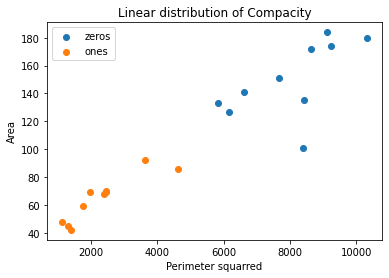

In [25]:
from skimage.measure import regionprops

compacity0 = []
compacity1 = []

perimeters0 = []
perimeters1 = []

areas0 = []
areas1 = []

for i in binary0:  
    regions0 = regionprops(i.astype('int'))
    perimeter0 = regions0[0].perimeter
    perimeters0.append(perimeter0**2)
    area0 = regions0[0].area
    areas0.append(area0)
    compacity0.append(perimeter0**2 / area0)
    
for j in binary1:
    regions1 = regionprops(j.astype('int'))
    perimeter1 = regions1[0].perimeter
    perimeters1.append(perimeter1**2)
    area1 = regions1[0].area
    areas1.append(area1)
    compacity1.append(perimeter1**2 / area1)

    
# Display the result (scatter plot)
plt.scatter(perimeters0, areas0, label = "zeros")
plt.scatter(perimeters1, areas1, label = "ones")
plt.title('Linear distribution of Compacity')
plt.xlabel('Perimeter squarred')
plt.ylabel('Area')
plt.legend()
plt.show()

As seen in class, the compacity is invariant in translation, rotation and scaling as we only look at the area and the perimeter of the object. As we can see on the plot, the ones and the zeros are really well separated. The ones are well clustered and the zeros are a little bit more spread.

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

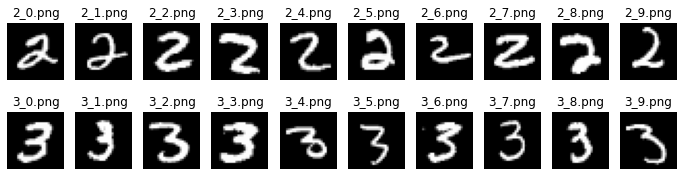

In [26]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In [27]:
def Area(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def extract_contours(images):
    out = []
    for im in images:
        contours=find_contours(im, 2.0)
        contours_areas=[Area(x[:,0],x[:,1]) for x in contours]
        out.append(contours[np.argmax(np.asarray(contours_areas))])
    return out

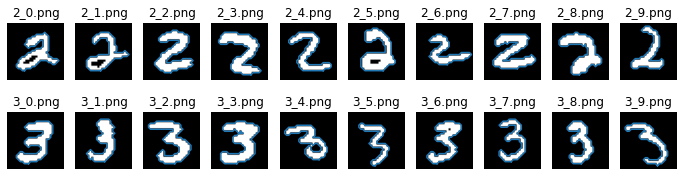

In [28]:
# Binarization
twos_bin, threes_bin = binarization(twos_im, threes_im)

#Contours
contour2 = extract_contours(twos_bin)
contour3 = extract_contours(threes_bin)
    
# Plot images
plotDigits(twos_bin, threes_bin, contour2, contour3, twos_names, threes_names)

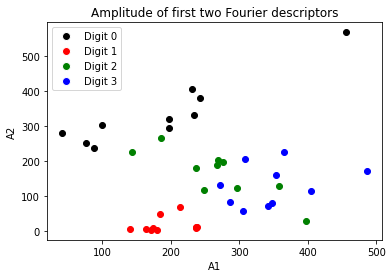

In [29]:
plt.figure()
plt.title('Amplitude of first two Fourier descriptors')
plt.xlabel('A1')
plt.ylabel('A2')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Digit 0',
                          markerfacecolor='k', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Digit 1',
                          markerfacecolor='r', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Digit 2',
                          markerfacecolor='g', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Digit 3',
                          markerfacecolor='b', markersize=8)]
        
plt.legend(handles=legend_elements)

for im0, im1, im2, im3, nm0, nm1, nm2, nm3 in zip(binary0, binary1, twos_bin, threes_bin, zeros_names, ones_names, twos_names, threes_names):
    
    # Digit 0
    fft0 = fourrier(im0)
    A1_0 = abs(fft0[1]) # First amplitude
    A2_0 = abs(fft0[2]) # Second amplitude
    plt.scatter(A1_0, A2_0, c='k')
    
    # Digit 1
    fft1 = fourrier(im1)
    A1_1 = abs(fft1[1]) # First amplitude
    A2_1 = abs(fft1[2]) # Second amplitude
    plt.scatter(A1_1, A2_1, c='r')
    
    #Digit 2
    fft2 = fourrier(im2)
    A1_2 = abs(fft2[1]) # First amplitude
    A2_2 = abs(fft2[2]) # Second amplitude
    plt.scatter(A1_2, A2_2, c='g')
    
    
    #Digit 3
    fft3 = fourrier(im3)
    A1_3 = abs(fft3[1]) # First amplitude
    A2_3 = abs(fft3[2]) # Second amplitude
    plt.scatter(A1_3, A2_3, c='b')

We can see that we can't separate the 4 digits when using the 2 first Fourrier coefficients.

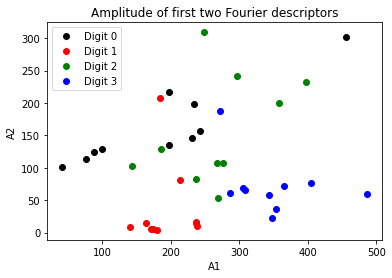

In [30]:
plt.figure()
plt.title('Amplitude of first two Fourier descriptors')
plt.xlabel('A1')
plt.ylabel('A2')
plt.legend(handles=legend_elements)

for im0, im1, im2, im3, nm0, nm1, nm2, nm3 in zip(binary0, binary1, twos_bin, threes_bin, zeros_names, ones_names, twos_names, threes_names):
    
    # Digit 0
    fft0 = fourrier(im0)
    A1_0 = abs(fft0[1]) # First amplitude
    A2_0 = abs(fft0[3]) # Second amplitude
    plt.scatter(A1_0, A2_0, c='k')
    
    # Digit 1
    fft1 = fourrier(im1)
    A1_1 = abs(fft1[1]) # First amplitude
    A2_1 = abs(fft1[3]) # Second amplitude
    plt.scatter(A1_1, A2_1, c='r')
    
    #Digit 2
    fft2 = fourrier(im2)
    A1_2 = abs(fft2[1]) # First amplitude
    A2_2 = abs(fft2[3]) # Second amplitude
    plt.scatter(A1_2, A2_2, c='g')
    
    
    #Digit 3
    fft3 = fourrier(im3)
    A1_3 = abs(fft3[1]) # First amplitude
    A2_3 = abs(fft3[3]) # Second amplitude
    plt.scatter(A1_3, A2_3, c='b')

We see that when we use the first and the third coefficients, it is a little bit better. There are still some outliers but a bigger dataset could maybe resolve that issue.